In [115]:


import cv2
import numpy as np
import numpy.linalg as lin








def getcos(combination_list) :
    v1 = combination_list[1] - combination_list[0]
    v2 = combination_list[2] - combination_list[0]
    cos = np.dot(v1, v2) / (np.linalg.norm(v1, ord=2)*np.linalg.norm(v2, ord=2))
    
    return abs(cos)

def test_line_num(point_lists) :
    for i in range(len(point_lists)-3) :
        if getcos(np.array(point_lists[i:i+3])) < 0.999 :
            print('detected 2 lines')
            return i
            
    
    print('detected 1 lines')
    return 0


def equation(point_list1, point_list2) :
    x11 = point_list1[0][0]
    y11 = point_list1[0][1]
    x12 = point_list1[1][0]
    y12 = point_list1[1][1]
    
    x21 = point_list2[0][0]
    y21 = point_list2[0][1]
    x22 = point_list2[1][0]
    y22 = point_list2[1][1]
    
    A = np.array([[y12-y11, -x12+x11],
                  [y22-y21, -x22+x21]])    
    inv_A = lin.inv(A)
    X = np.array([x11*y12-x12*y11, x21*y22-x22*y21])
    
    result = np.dot(inv_A, X.T)
    
    return result


import matplotlib.pyplot as plt

def graph_(lists) :
    x = []
    y = []
    for i in lists :
        x.append(i[1])
        y.append(i[0])
    plt.plot(x,  # x
             y,  # y 
             linestyle='none', 
             marker='o', 
             markersize=10,
             color='blue', 
             alpha=0.5)
    plt.show()

In [119]:
img_path = '/Users/gkalstn/capstone/test_images/img0.jpeg'

image_np = cv2.imread(img_path)

In [ ]:
    h, w = image_np[:,:,0].shape
    
    if (h > 1000) or (w > 1000) :
        h, w = int(h/3), int(w/3)
        image_np = cv2.resize(image_np, dsize=(w, h), interpolation=cv2.INTER_AREA)

    no_background = np.zeros((h, w))

    for i in range(h) :
        for j in range(w) :
            if (image_np[i,j,0] > image_np[i,j,1]) and (image_np[i,j,1] > image_np[i,j,2] and (image_np[i,j,0]=>190)) and (image_np[i,j,2]>170):
                no_background[i, j] = image_np[i, j, 0]

        
   

    for i in range(h) :
        for j in range(w) :
            if no_background[i, j] != 0 :
                no_background[i, j] = 200



    w_list = np.linspace(0, w-1, 17)
    h_list = np.linspace(0, h-1, 17)


    right = []
    left = []

#아래에서 검사 찾은 변이 2개 or 1개
    for i in h_list :
        i = int(i)
        lists = no_background[i, :].tolist()
    
        if(not (200 in lists)) :
            continue
    
        for j in range(w) :
            if no_background[i, w-1-j] == 200 :
                right.append([i, w-1-j])
                break

        for j in range(w) :
            if no_background[i, j] == 200 :
                left.append([i, j])
                break
        



    s1 = []
    s2 = []
    s3 = []
    s4 = []

    piv1 = test_line_num(right)
    piv2 = test_line_num(left)

    if piv1 == 0 :
        s1 = right
        if left[-1][-1] > left[0][-1] :
            s3 += left[:piv2]
            s2 += left[piv2+4:]
        else :
            s2 += left[:piv2]
            s3 += left[piv2+4:]
        
        for i in w_list :
            i = int(i)
            lists = no_background[i, :].tolist()
    
            if(not (200 in lists)) :
                continue
    
            for j in range(h) :
                if no_background[h-j-1, i] == 200 :
                    s4.append([h-j-1, i])
                    break
        
        
    
    else :
        s1 += right[:piv1]
        s2 += right[piv1+4:]
        s4 += left[:piv2]
        s3 += left[piv2+4:]
    
    

    p1 = equation(s1, s2)
    p2 = equation(s2, s3)
    p3 = equation(s3, s4)
    p4 = equation(s4, s1)


    
    point_list = [p1, p2, p3, p4]
    print(point_list)
    return point_list

In [122]:
image_np.shape

(567, 1290, 3)

In [123]:
b = []
r = []
g = []

for i in range(567) :
    b.append(image_np[i, i, 0])
    r.append(image_np[i, i, 1])
    g.append(image_np[i, i, 2])

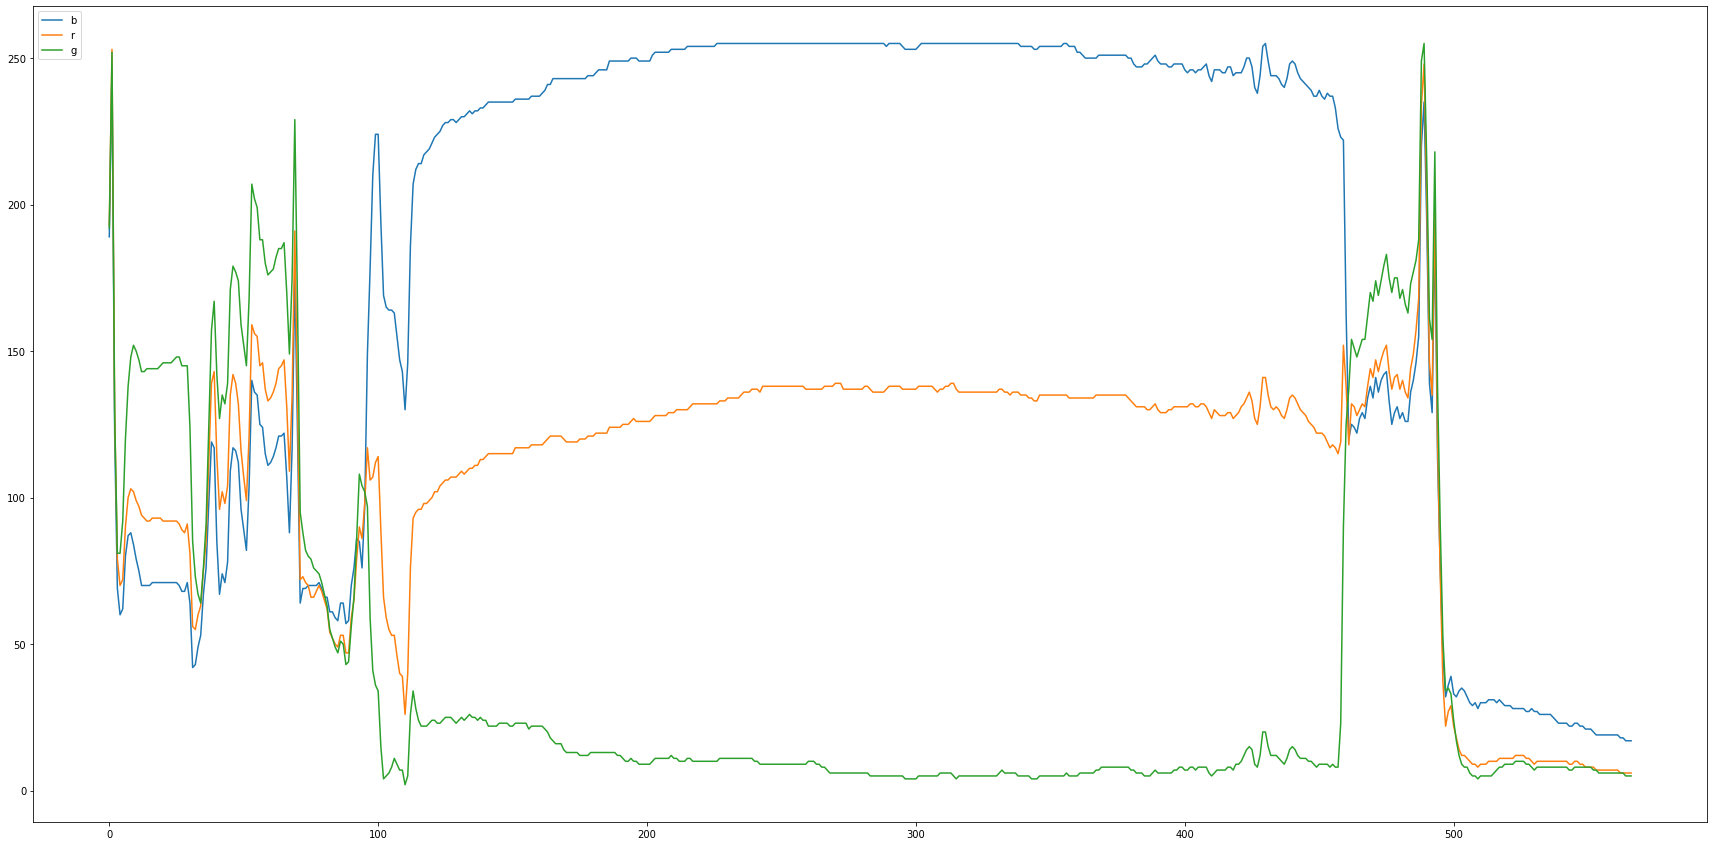

In [166]:
import matplotlib.pyplot as plt
min_ = 0
max_ = 567
x = np.arange(min_, max_)
plt.plot(x, b[min_:max_], label = 'b')
plt.plot(x, r[min_:max_], label = 'r')
plt.plot(x, g[min_:max_], label = 'g')
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"] = (30,15)
plt.show()

In [165]:
b_ = np.array(b[min_: max_])
g_ = np.array(g[min_: max_])
r_ = np.array(r[min_: max_])

br = b_-r_
rg = r_-g_

min(rg)


67

[189,
 247,
 122,
 69,
 60,
 62,
 80,
 87,
 88,
 84,
 79,
 75,
 70,
 70,
 70,
 70,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 70,
 68,
 68,
 71,
 64,
 42,
 43,
 49,
 53,
 67,
 76,
 98,
 119,
 117,
 85,
 67,
 74,
 71,
 78,
 109,
 117,
 116,
 112,
 96,
 89,
 82,
 104,
 140,
 136,
 135,
 125,
 124,
 115,
 111,
 112,
 114,
 117,
 121,
 121,
 122,
 107,
 88,
 117,
 176,
 122,
 64,
 69,
 69,
 70,
 70,
 70,
 70,
 71,
 69,
 66,
 66,
 61,
 61,
 59,
 58,
 64,
 64,
 57,
 58,
 70,
 76,
 86,
 85,
 76,
 97,
 149,
 178,
 210,
 224,
 224,
 194,
 169,
 165,
 164,
 164,
 163,
 155,
 147,
 143,
 130,
 146,
 186,
 207,
 212,
 214,
 214,
 217,
 218,
 219,
 221,
 223,
 224,
 225,
 227,
 228,
 228,
 229,
 229,
 228,
 229,
 230,
 230,
 231,
 232,
 231,
 232,
 232,
 233,
 233,
 234,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 235,
 236,
 236,
 236,
 236,
 236,
 236,
 237,
 237,
 237,
 237,
 238,
 239,
 241,
 241,
 243,
 243,
 243,
 243,
 243,
 243,
 243,
 243,
 243,
 243,
 243,
 243,
 243,
 